# Importation des librairies et données

### Chargement des librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras as ks

from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold #Conserve la répartition pendant la séparation
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

### Importation de la base

In [3]:
# On utilise la base de données complète pour les statistiques descriptives
data = pd.read_csv("/Users/cecilemocher/Documents/M2/SVM-ANN/ProjetSVM/ventilator-pressure-prediction/train.csv", sep=",")


# EDA

## Analyse de forme

In [4]:
#Aperçu de la base
data.head(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699
8,9,1,20,50,0.271776,27.864715,0,15.539188
9,10,1,20,50,0.305732,28.313036,0,15.750094


In [5]:
# Suppresion de la colonne id qui ne nous sera pas utile
data = data.drop(columns=['id'])

<AxesSubplot:>

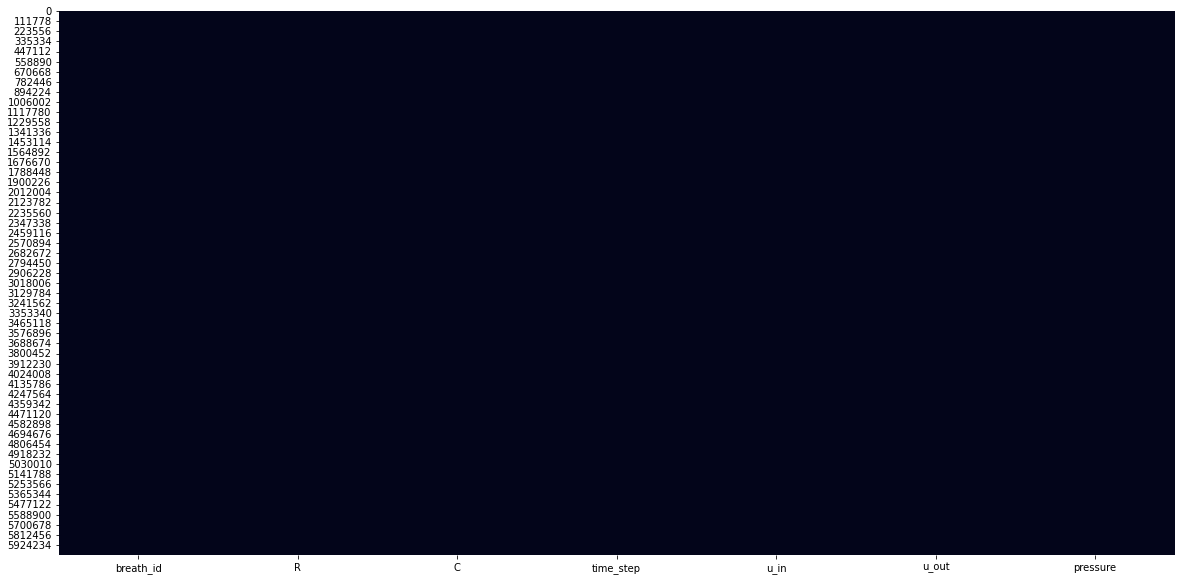

In [6]:
#Graphique des valeurs manqantes
plt.figure(figsize=(20,10))
sns.heatmap(data.isna(), cbar=False) #Graphique entièrement noir donc aucune valeur manquante

In [7]:
#Confirmation de la non présence de valeurs manquantes
data.isna().sum()/data.shape[0]

breath_id    0.0
R            0.0
C            0.0
time_step    0.0
u_in         0.0
u_out        0.0
pressure     0.0
dtype: float64

In [8]:
#Dimension de la base
data.shape

(6036000, 7)

In [9]:
#Type des variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 7 columns):
breath_id    int64
R            int64
C            int64
time_step    float64
u_in         float64
u_out        int64
pressure     float64
dtypes: float64(3), int64(4)
memory usage: 322.4 MB


In [10]:
#Nombre de variable par type
data.dtypes.value_counts()

int64      4
float64    3
dtype: int64

## Analyse de fond

In [11]:
#Statistiques descriptives de la base
data.describe().round(2)

,breath_id,R,C,time_step,u_in,u_out,pressure
count,6036000.00,6036000.00,6036000.00,6036000.00,6036000.00,6036000.00,6036000.00
mean,62838.86,27.04,26.08,1.31,7.32,0.62,11.22
std,36335.26,19.60,17.15,0.77,13.43,0.49,8.11
min,1.00,5.00,10.00,0.00,0.00,0.00,-1.90
25%,31377.00,5.00,10.00,0.64,0.39,0.00,6.33
50%,62765.50,20.00,20.00,1.31,4.39,1.00,7.03
75%,94301.00,50.00,50.00,1.97,4.98,1.00,13.64
max,125749.00,50.00,50.00,2.94,100.00,1.00,64.82


In [12]:
#Médiane de la variable à expliquer
data.pressure.median()

7.032628177739799

In [13]:
#Corrélation entre les variables
data.corr()

,breath_id,R,C,time_step,u_in,u_out,pressure
breath_id,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


### Gaphiques

<AxesSubplot:>

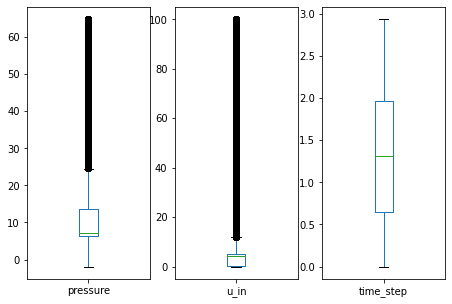

In [14]:
# Boxplot des variables float
plt.figure(figsize=(7.5,5))
plt.subplot(1,3,1)
data.boxplot('pressure', grid=False)
plt.subplot(1,3,2)
data.boxplot('u_in', grid = False)
plt.subplot(1,3,3)
data.boxplot('time_step', grid=False)

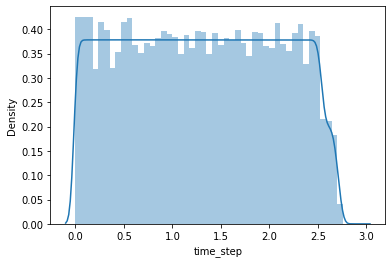

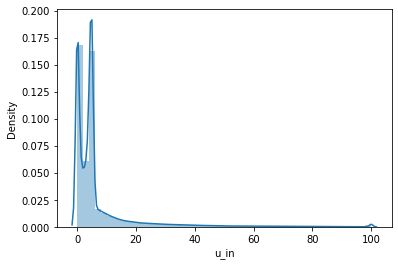

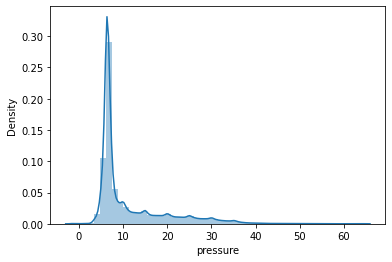

In [15]:
#Graphique de la distribution des variables réelles
for col in data.select_dtypes('float'):
    plt.figure()
    sns.distplot(data[col])

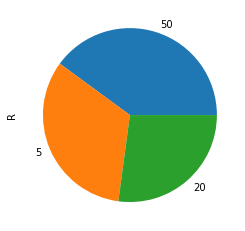

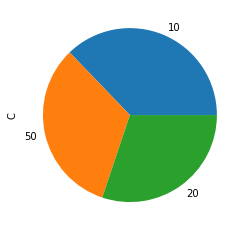

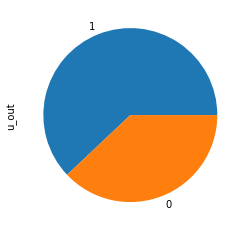

In [16]:
# Suppresion de la colonne breath_id qui ne nous sera pas utile pour les graphiques suivants
data_int = data.drop(columns=['breath_id'])

for col in data_int.select_dtypes('int64'):
    plt.figure()
    data_int[col].value_counts().plot.pie()

Text(0.5, 1.0, "Nombre d'observations dans chaque modalité de la variable 'R'")

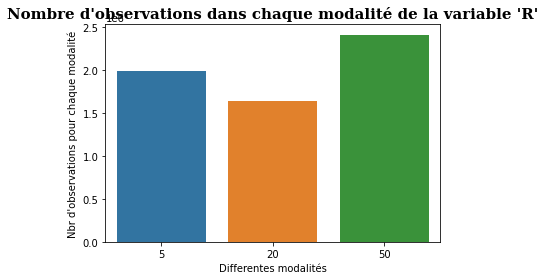

In [17]:
#Effectifs des différentes modalités de la variable R
sns.countplot(data.R)
plt.xlabel('Differentes modalités')
plt.ylabel("Nbr d'observations pour chaque modalité")
plt.title("Nombre d'observations dans chaque modalité de la variable 'R'",
          fontsize=15,family = 'serif',fontweight = 'bold')

Text(0.5, 1.0, "Nombre d'observations dans chaque modalité de la variable 'C'")

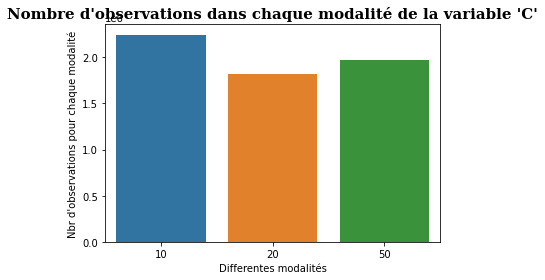

In [18]:
#Effectifs des différentes modalités de la variable c
sns.countplot(data.C)
plt.xlabel('Differentes modalités')
plt.ylabel("Nbr d'observations pour chaque modalité")
plt.title("Nombre d'observations dans chaque modalité de la variable 'C'",
          fontsize=15,family = 'serif',fontweight = 'bold')

Text(0.5, 1.0, "Nombre d'observations dans chaque modalité de la variable 'u_out'")

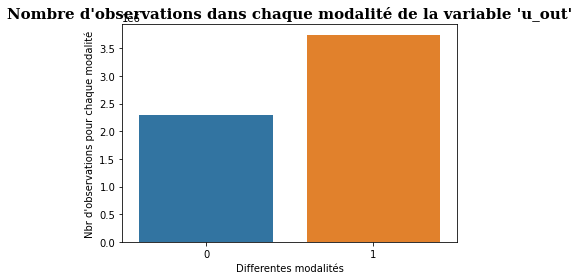

In [19]:
#Effectifs des différentes modalités de la variable u_out
sns.countplot(data.u_out)
plt.xlabel('Differentes modalités')
plt.ylabel("Nbr d'observations pour chaque modalité")
plt.title("Nombre d'observations dans chaque modalité de la variable 'u_out'",
          fontsize=15,family = 'serif',fontweight = 'bold')

### Relation Target/ Features

#### Création des matrices target et features

In [20]:
y = np.asarray(data.pressure)
X = np.array(data.drop(columns = ["pressure"]))

In [21]:
y = y.reshape(-1,1)
print(y.shape)

(6036000, 1)


#### Transformation de la variable y en variable binaire

In [22]:
#Transformation de la variable à expliquer en variable discrète (utilisation de la médiane comme seuil)
y = Binarizer(threshold= 7.03).fit_transform(y)  # Nos classes sont donc équilibrées

In [23]:
#Ajout de la variable binaire au dataframe
data['y'] = y

In [24]:
data.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,y
0,1,20,50,0.000000,0.083334,0,5.837492,0.0
1,1,20,50,0.033652,18.383041,0,5.907794,0.0
2,1,20,50,0.067514,22.509278,0,7.876254,1.0
3,1,20,50,0.101542,22.808822,0,11.742872,1.0
4,1,20,50,0.135756,25.355850,0,12.234987,1.0


In [25]:
data.shape

(6036000, 8)

#### Création de sous ensemble pour la variable pressure

In [26]:
data_inf = data[data['pressure'] <= 7.03]
data_sup = data[data['pressure'] > 7.03]

#### Représentations graphiques

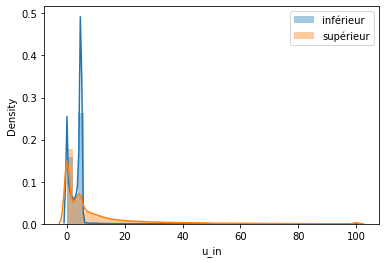

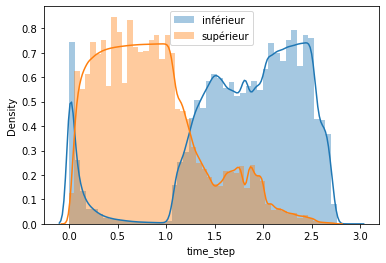

In [27]:
plt.figure()
sns.distplot(data_inf['u_in'], label = 'inférieur')
sns.distplot(data_sup['u_in'], label = 'supérieur')
plt.legend()
plt.figure()
sns.distplot(data_inf['time_step'], label = 'inférieur')
sns.distplot(data_sup['time_step'], label = 'supérieur')
plt.legend()

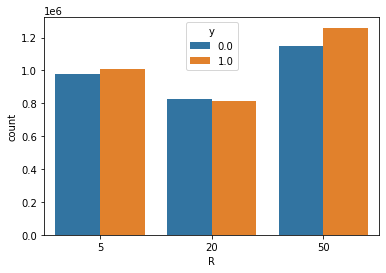

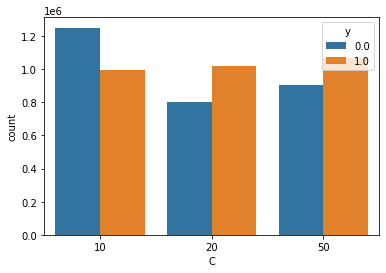

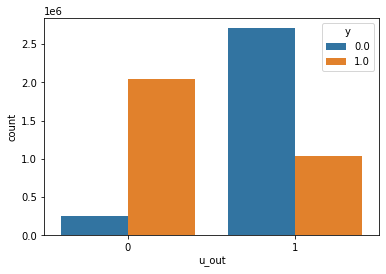

In [29]:
#Ajout de la variable binaire à data_int
data_int['y'] = y

for col in data_int.select_dtypes('int64'):
    plt.figure()
    sns.countplot(x=col, hue='y', data= data_int)

# Partitionnement des données

#### Création des jeux d'entrainement et de test

In [49]:
# On utilise un échantillon de 2000 observations pour nos modélisations
data = pd.read_csv("/Users/cecilemocher/Documents/M2/SVM-ANN/ProjetSVM/ventilator-pressure-prediction/train.csv", sep=",", nrows=2000) 
#nrows on ne garde que 2000 lignes

In [50]:
# Suppresion de la colonne id qui ne nous sera pas utile
data = data.drop(columns=['id'])

In [51]:
y = np.asarray(data.pressure)
X = np.array(data.drop(columns = ["pressure"]))
y = y.reshape(-1,1)

In [52]:
#Transformation de la variable à expliquer en variable discrète (utilisation de la médiane comme seuil)
y = Binarizer(threshold= 7.03).fit_transform(y)  # Nos classes sont donc équilibrées

In [53]:
#Ajout de la variable binaire au dataframe
data['y'] = y
data.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,y
0,1,20,50,0.000000,0.083334,0,5.837492,0.0
1,1,20,50,0.033652,18.383041,0,5.907794,0.0
2,1,20,50,0.067514,22.509278,0,7.876254,1.0
3,1,20,50,0.101542,22.808822,0,11.742872,1.0
4,1,20,50,0.135756,25.355850,0,12.234987,1.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify=y, random_state =56)
# ajouter stratify=y pour une variable quali pour conserver les répartitions du dataset
#random_state comme seed fixe nos train et test data => n'importe quel nombre
#sinon dès qu'on run train_test_split on a des data diff

In [37]:
# Passage en forme matricielle
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
X_test=np.asarray(X_test)

In [38]:
# KFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=586)

# Régression logistique

In [39]:
# Setup de la pipeline
steps = [('scaler', StandardScaler()), #Standardisation des données
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)

# Spécification de l'hyperparamètre
c_space = np.logspace(-5, 8, 15)
parameters = {'logreg__C':c_space}

# Recherche des meilleurs hyperparamètres avec GridSearchCV
logreg_cv = GridSearchCV(pipeline, parameters, cv=folds)

# Fit du modèle de training
logreg_cv.fit(X_train, y_train)

# Prediction sur le test set
y_predlog = logreg_cv.predict(X_test)
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

# Informations sur le modèle standardisé
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))  #R²
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
print("Confusion Matrix: {}".format(confusion_matrix(y_test,y_predlog)))
print(classification_report(y_test, y_predlog)) # tableau avec recall et précision 
#on a idéntifier 80% des cas positif (recall de 1 = 0.8)
print("Tuned Model Parameters: {}".format(logreg_cv.best_params_)) #meilleurs paramètres     

Accuracy: 0.8425
AUC: 0.890406162464986
Confusion Matrix: [[177  19]
 [ 44 160]]
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       196
         1.0       0.89      0.78      0.84       204

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400

Tuned Model Parameters: {'logreg__C': 31.622776601683793}


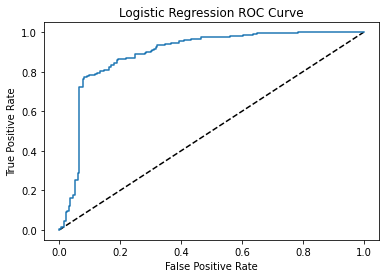

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot de la courbe de ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

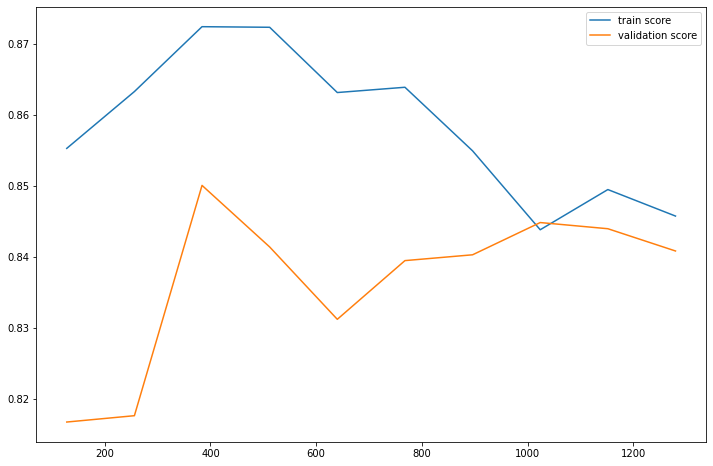

In [41]:
#Learning curve
N, train_score, val_score = learning_curve(logreg_cv, X_train, y_train, cv=5, scoring='f1', train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(12,8))
plt.plot(N,train_score.mean(axis=1), label='train score')
plt.plot(N,val_score.mean(axis=1), label='validation score')
plt.legend()

# SVM

### Kernel = 'linear'

In [42]:
# Setup de la pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(kernel='linear'))]

pipeline = Pipeline(steps)

# Spécification des hyperparamètres
parameters = {'SVM__C':[1, 10, 100]}

# Recherche des meilleurs hyperparapmètres avec GridSearchCV
svm_cv = GridSearchCV(pipeline, parameters, cv=folds)

# Fit du modèle de training
svm_cv.fit(X_train, y_train)

# Prediction sur le test set
y_preds = svm_cv.predict(X_test)

# Informations sur le modèle standardisé
print("Accuracy: {}".format(svm_cv.score(X_test, y_test)))  #R²
print("Confusion Matrix: {}".format(confusion_matrix(y_test,y_preds)))
print(classification_report(y_test, y_preds)) # tableau avec recall et précision
print("Tuned Model Parameters: {}".format(svm_cv.best_params_)) #meilleurs paramètres

Accuracy: 0.8075
Confusion Matrix: [[183  13]
 [ 64 140]]
              precision    recall  f1-score   support

         0.0       0.74      0.93      0.83       196
         1.0       0.92      0.69      0.78       204

    accuracy                           0.81       400
   macro avg       0.83      0.81      0.81       400
weighted avg       0.83      0.81      0.80       400

Tuned Model Parameters: {'SVM__C': 1}


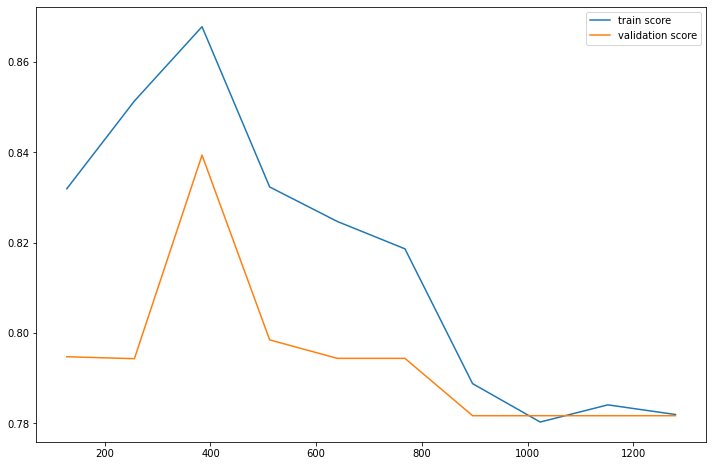

In [43]:
#Learning curve
N, train_score, val_score = learning_curve(svm_cv, X_train, y_train, cv=5, scoring='f1', train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(12,8))
plt.plot(N,train_score.mean(axis=1), label='train score')
plt.plot(N,val_score.mean(axis=1), label='validation score')
plt.legend()

### Kernel = 'rbf'

In [44]:
# Setup de la pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

# Spécification des hyperparamètres
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01, 0.001, 0.0001]}

# Recherche des meilleurs hyperparapmètres avec GridSearchCV
svm2_cv = GridSearchCV(pipeline, parameters, cv=folds)

# Fit du modèle de training
svm2_cv.fit(X_train, y_train)

# Prediction sur le test set
y_preds2 = svm2_cv.predict(X_test)

# Informations sur le modèle standardisé
print("Accuracy: {}".format(svm2_cv.score(X_test, y_test)))  #R²
print("Confusion Matrix: {}".format(confusion_matrix(y_test,y_preds2)))
print(classification_report(y_test, y_preds2)) # tableau avec recall et précision
print("Tuned Model Parameters: {}".format(svm2_cv.best_params_)) #meilleurs paramètres

Accuracy: 0.9075
Confusion Matrix: [[184  12]
 [ 25 179]]
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       196
         1.0       0.94      0.88      0.91       204

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.1}


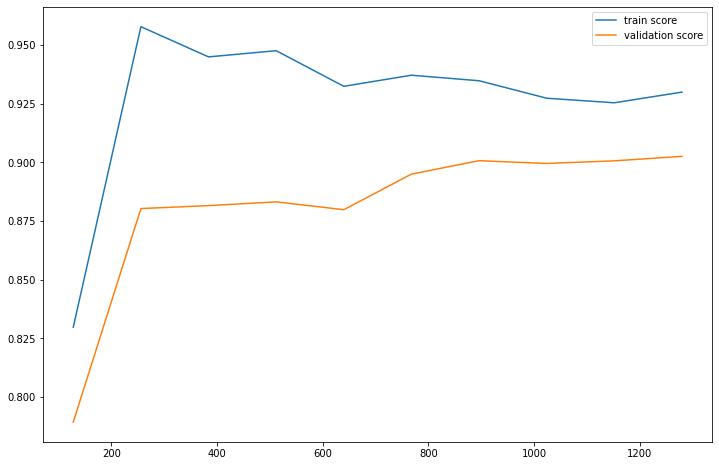

In [45]:
#Learning curve
N, train_score, val_score = learning_curve(svm2_cv, X_train, y_train, cv=5, scoring='f1', train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(12,8))
plt.plot(N,train_score.mean(axis=1), label='train score')
plt.plot(N,val_score.mean(axis=1), label='validation score')
plt.legend()

# ANN

### Optimisation de batch_size et epochs

In [54]:
data.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,y
0,1,20,50,0.000000,0.083334,0,5.837492,0.0
1,1,20,50,0.033652,18.383041,0,5.907794,0.0
2,1,20,50,0.067514,22.509278,0,7.876254,1.0
3,1,20,50,0.101542,22.808822,0,11.742872,1.0
4,1,20,50,0.135756,25.355850,0,12.234987,1.0


In [55]:
#Réencodage des variables
X = data.iloc[:,0:5]
y = data.iloc[:,7]

In [56]:
# Création du jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify=y, random_state =56)

In [57]:
#Fonction créant un modèle de réseaux de neurones
def create_model ():
    my_model = Sequential()
    my_model.add(Dense(10, input_dim = 5, activation='relu'))
    my_model.add(Dense(1,activation='sigmoid'))
    
    my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    return my_model

In [58]:
#Création du modèle
model = KerasClassifier(build_fn=create_model)

In [59]:
# Paramètres à tester
batchSize = [5, 10, 20, 40]
epochs = [30, 50, 100, 150]

In [60]:
#Tuning des paramètres batch_size et epochs
parameter_grid = dict(batch_size=batchSize, epochs=epochs)

grid = GridSearchCV(estimator = model, param_grid = parameter_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/150
160/160 [==============================] - 1s 1ms/step - loss: 3.0821 - accuracy: 0.4481
Epoch 2/150
160/160 [==============================] - 0s 909us/step - loss: 1.0315 - accuracy: 0.5138
Epoch 3/150
160/160 [==============================] - 0s 798us/step - loss: 0.7120 - accuracy: 0.6019
Epoch 4/150
160/160 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.6550
Epoch 5/150
160/160 [==============================] - 0s 1ms/step - loss: 0.5633 - accuracy: 0.7075
Epoch 6/150
160/160 [==============================] - 0s 1ms/step - loss: 0.5362 - accuracy: 0.7325
Epoch 7/150
160/160 [==============================] - 0s 723us/step - loss: 0.5184 - accuracy: 0.7369
Epoch 8/150
160/160 [==============================] - 0s 811us/step - loss: 0.5053 - accuracy: 0.7500
Epoch 9/150
160/160 [==============================] - 0s 804us/step - loss: 0.4944 - accuracy: 0.7594
Epoch 10/150
160/160 [==============================] - 0s 767us/step - loss: 0.4

160/160 [==============================] - 0s 706us/step - loss: 0.3704 - accuracy: 0.8581
Epoch 81/150
160/160 [==============================] - 0s 923us/step - loss: 0.3679 - accuracy: 0.8550
Epoch 82/150
160/160 [==============================] - 0s 682us/step - loss: 0.3651 - accuracy: 0.8569
Epoch 83/150
160/160 [==============================] - 0s 812us/step - loss: 0.3600 - accuracy: 0.8644
Epoch 84/150
160/160 [==============================] - 0s 765us/step - loss: 0.3626 - accuracy: 0.8600
Epoch 85/150
160/160 [==============================] - 0s 841us/step - loss: 0.3604 - accuracy: 0.8681
Epoch 86/150
160/160 [==============================] - 0s 819us/step - loss: 0.3619 - accuracy: 0.8606
Epoch 87/150
160/160 [==============================] - 0s 746us/step - loss: 0.3615 - accuracy: 0.8587
Epoch 88/150
160/160 [==============================] - 0s 692us/step - loss: 0.3572 - accuracy: 0.8619
Epoch 89/150
160/160 [==============================] - 0s 707us/step - loss:

In [61]:
#Meilleurs score et paramètres
print('Best accuracy: %f using the parameters %s' % (grid_result.best_score_,grid_result.best_params_ ))


Best accuracy: 0.853742 using the parameters {'batch_size': 10, 'epochs': 150}


### Optimisation des fonctions d'optimisation et d'activation

In [66]:
#Fonction créant un modèle de réseaux de neurones
def create_model (optimizer='adam', activation ='relu'):
    my_model = Sequential()
    my_model.add(Dense(10, input_dim = 5, activation=activation))
    my_model.add(Dense(1,activation='sigmoid'))
    
    my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy'])
    return my_model

In [67]:
#Création du modèle avec les paramèteres epochs et batch_size trouvés précédement
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10)

In [68]:
# Paramètre à tester
optimizer = ['SGD','Adam']
activation = ['relu', 'tanh']

In [69]:
#Tuning des paramètres optimizer et activation
parameter_grid = dict(optimizer=optimizer, activation=activation)

grid = GridSearchCV(estimator = model, param_grid = parameter_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/150
160/160 [==============================] - 1s 1ms/step - loss: 0.7064 - accuracy: 0.6162
Epoch 2/150
160/160 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.6325
Epoch 3/150
160/160 [==============================] - 0s 1ms/step - loss: 0.6182 - accuracy: 0.6569
Epoch 4/150
160/160 [==============================] - 0s 1ms/step - loss: 0.6031 - accuracy: 0.6750
Epoch 5/150
160/160 [==============================] - 0s 2ms/step - loss: 0.5846 - accuracy: 0.6837
Epoch 6/150
160/160 [==============================] - 0s 779us/step - loss: 0.5547 - accuracy: 0.6931
Epoch 7/150
160/160 [==============================] - 0s 772us/step - loss: 0.5346 - accuracy: 0.7225
Epoch 8/150
160/160 [==============================] - 0s 926us/step - loss: 0.5193 - accuracy: 0.7531
Epoch 9/150
160/160 [==============================] - 0s 975us/step - loss: 0.5048 - accuracy: 0.7688
Epoch 10/150
160/160 [==============================] - 0s 841us/step - loss: 0.490

160/160 [==============================] - 0s 769us/step - loss: 0.3275 - accuracy: 0.8681
Epoch 81/150
160/160 [==============================] - 0s 735us/step - loss: 0.3213 - accuracy: 0.8719
Epoch 82/150
160/160 [==============================] - 0s 704us/step - loss: 0.3181 - accuracy: 0.8669
Epoch 83/150
160/160 [==============================] - 0s 707us/step - loss: 0.3165 - accuracy: 0.8744
Epoch 84/150
160/160 [==============================] - 0s 687us/step - loss: 0.3200 - accuracy: 0.8687
Epoch 85/150
160/160 [==============================] - 0s 749us/step - loss: 0.3148 - accuracy: 0.8731
Epoch 86/150
160/160 [==============================] - 0s 729us/step - loss: 0.3190 - accuracy: 0.8681
Epoch 87/150
160/160 [==============================] - 0s 683us/step - loss: 0.3184 - accuracy: 0.8669
Epoch 88/150
160/160 [==============================] - 0s 707us/step - loss: 0.3210 - accuracy: 0.8662
Epoch 89/150
160/160 [==============================] - 0s 699us/step - loss:

In [39]:
#Meilleurs score et paramètres
print('Best accuracy: %f using the parameters %s' % (grid_result.best_score_,grid_result.best_params_ ))

Best accuracy: 0.890618 using the parameters {'activation': 'tanh', 'optimizer': 'Adam'}


### Optimisation du nombre de neurones et de couches

In [70]:
#Fonction créant un modèle de réseaux de neurones, avec les fonctions adam et relu trouvées précédement
def create_model (nn=10, nl=1):
    my_model = Sequential()
    my_model.add(Dense(10, input_dim = 5, activation='tanh'))
    for i in range(nl):
        my_model.add(Dense(nn,activation='tanh'))
    my_model.add(Dense(1,activation='sigmoid'))
    my_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
    return my_model

In [71]:
#Création du modèle avec les paramèteres epochs et batch_size trouvés précédement
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10)

In [72]:
# Paramètre à tester
nl = [1,2,3]
nn = [10, 20, 40, 60]

In [73]:
#Tuning du nombre de couches cachées et du nombre de neurones
parameter_grid = dict(nl=nl,nn=nn)

grid = GridSearchCV(estimator = model, param_grid = parameter_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/150
160/160 [==============================] - 1s 1ms/step - loss: 0.6771 - accuracy: 0.5981
Epoch 2/150
160/160 [==============================] - 0s 1ms/step - loss: 0.6324 - accuracy: 0.6475
Epoch 3/150
160/160 [==============================] - 0s 882us/step - loss: 0.6041 - accuracy: 0.6675
Epoch 4/150
160/160 [==============================] - 0s 945us/step - loss: 0.5837 - accuracy: 0.6787
Epoch 5/150
160/160 [==============================] - 0s 879us/step - loss: 0.5684 - accuracy: 0.6988
Epoch 6/150
160/160 [==============================] - 0s 872us/step - loss: 0.5388 - accuracy: 0.7244
Epoch 7/150
160/160 [==============================] - 0s 849us/step - loss: 0.4922 - accuracy: 0.7781
Epoch 8/150
160/160 [==============================] - 0s 884us/step - loss: 0.4636 - accuracy: 0.7925
Epoch 9/150
160/160 [==============================] - 0s 905us/step - loss: 0.4495 - accuracy: 0.7987
Epoch 10/150
160/160 [==============================] - 0s 895us/step - loss:

160/160 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.8731
Epoch 82/150
160/160 [==============================] - 0s 1ms/step - loss: 0.3029 - accuracy: 0.8781
Epoch 83/150
160/160 [==============================] - 0s 1ms/step - loss: 0.3002 - accuracy: 0.8781
Epoch 84/150
160/160 [==============================] - 0s 1ms/step - loss: 0.3120 - accuracy: 0.8700
Epoch 85/150
160/160 [==============================] - 0s 1ms/step - loss: 0.2978 - accuracy: 0.8794
Epoch 86/150
160/160 [==============================] - 0s 1ms/step - loss: 0.3003 - accuracy: 0.8794
Epoch 87/150
160/160 [==============================] - 0s 1ms/step - loss: 0.3003 - accuracy: 0.8788
Epoch 88/150
160/160 [==============================] - 0s 945us/step - loss: 0.2999 - accuracy: 0.8750
Epoch 89/150
160/160 [==============================] - 0s 938us/step - loss: 0.2977 - accuracy: 0.8806
Epoch 90/150
160/160 [==============================] - 0s 1ms/step - loss: 0.3038 - accura

In [74]:
#Meilleur score et paramètres
print('Best accuracy: %f using %s' % (grid_result.best_score_,grid_result.best_params_ ))

Best accuracy: 0.871859 using {'nl': 3, 'nn': 10}


In [75]:
best_model = Sequential()
best_model.add(Dense(10, input_dim = 5, activation='tanh'))
best_model.add(Dense(10,activation='tanh'))
best_model.add(Dense(10,activation='tanh'))
best_model.add(Dense(10,activation='tanh'))
best_model.add(Dense(1,activation='sigmoid'))
best_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [76]:
#Fonction de perte des modèles ANN

def plot_history(history_best_model):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_best_model.history['loss'])
    axs[0].plot(history_best_model.history['val_loss'])
    axs[0].set_title('train and test loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epochs')
    axs[0].legend(['train', 'validation'], loc='upper left')

    axs[1].plot(history_best_model.history['accuracy'])
    axs[1].plot(history_best_model.history['val_accuracy'])
    axs[1].set_title('train and test accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epochs')
    axs[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


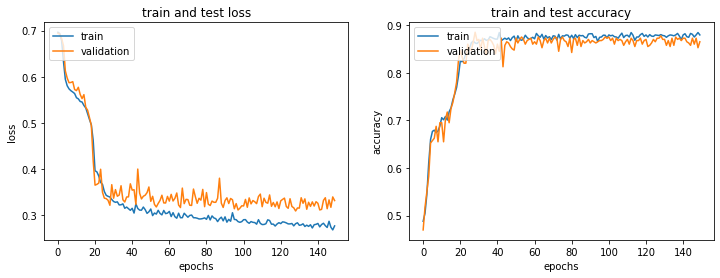

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [77]:
best_model.summary()

history_best_model = best_model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=150, 
                                    batch_size=10, verbose = 0)

plot_history(history_best_model)

y_predann = best_model.predict(X_test)

#La prediction ne fonctionne pas, la variable y_predann est considérée comme continue
#Tentative d'utiliser la méthode predict_classes sans succès
print(confusion_matrix(y_test, y_predann))
print(classification_report(y_test, y_predann))
print(model.evaluate(X_test, y_test)[1])